# Project Notes
this is about saving the amazon rainforest

# 10.ToDo's

## next to Dos
- balance dataset out
- find right weights
- find right loss function and metric
- apply these changes to the level4 architecture


## backlog
- tta
- use batch normalization layer
- use reduceLrOnPlateau
- output generation: apply label constraints on the result. e.g. only one weather label should be applied. if there are more, then keep only the most probable one.
- threshold optimization
- check out the f-beta metric
- check out the imbalanced dataset library?
- train another algorithm and then combine both algorithms in a ensemble learning fashion
- how can you use the cooccurence matrix to your advantage? is this a case fo a bayesian network?
- what do we learn from plotting the rgbn histograms?
- are there some rulesOfThumbs for the CNN Architecture and hyperParams?
- are there exotic preprocessings of the images like applying superresolution or removing the haze?

## history
- level8: cut imbalanced dataset by hand and turn weather stuff into a multiclass architecutre
- level7: balance dataset out for each of the three cnns (land labels, rare labels and weather labels) => no improvement
- level6: use 3 cnns for land labels, rare labels and weather labels => no improvement. also tried some theshold optimization => made everyting worse somehow
- level5: 256x256 rgb and learning rate 0.0001 => no improvement
- level4: normalization and augmentation added: now we are at 0.909 (best result so far). Running an additional run with learning rate reduced to 0...02
- result visualization complete: the only thing that I can see is that rare labels are too rare
- level3: using tiff did not help. 0.88: but you can see that including infrared helps a little bit. i messsed up the private score. maybe tiff is worse because of wrong rescaling and missing normalization. For now I continue with pdf and then I include near infrared again in the future.
- level2: the same cnn with 256x256 worked a little less good, but also 0.891
- level1: I got a cnn working by switching from accuracy to binary accuracy as a metric and 128x128 rgb and threshold 0.2. result: 0.899 (best result so far)
- submitting simply all labels yiels 0.48
- submitting the results from aa randomly init cnnyields 0.39

# 1.Import dependencies

In [1]:
import sys
import os
import subprocess

from six import string_types

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display

import random
from time import time
from glob import glob

from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots




import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
# !pip install -q torchsummary --user
# from torchsummary import summary

# 2.Load Data

In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("C:/Users/rzi/AmazonMLProject/input")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_TIF_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2')
PLANET_KAGGLE_TIF_TEST_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'test-tif-v2')
PLANET_KAGGLE_JPG_TEST_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'test-jpg')
PLANET_KAGGLE_JPG_TEST_EXTRA_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'test-jpg-additional')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
PLANET_KAGGLE_SUBMISSION_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'sample_submission_orig.csv')

assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_TIF_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)
assert os.path.exists(PLANET_KAGGLE_TIF_TEST_DIR)
assert os.path.exists(PLANET_KAGGLE_JPG_TEST_DIR)
assert os.path.exists(PLANET_KAGGLE_JPG_TEST_EXTRA_DIR)


In [3]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [5]:
# Add onehot features for every label
labels_df_original = labels_df.copy()
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


# 3.Explore Data

In [2]:
# Histogram of label instances
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation', 'road']
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
rare_labels = ['slash_burn', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']

labels_df[land_labels].sum().plot.bar()



NameError: name 'labels_df' is not defined

<Axes: >

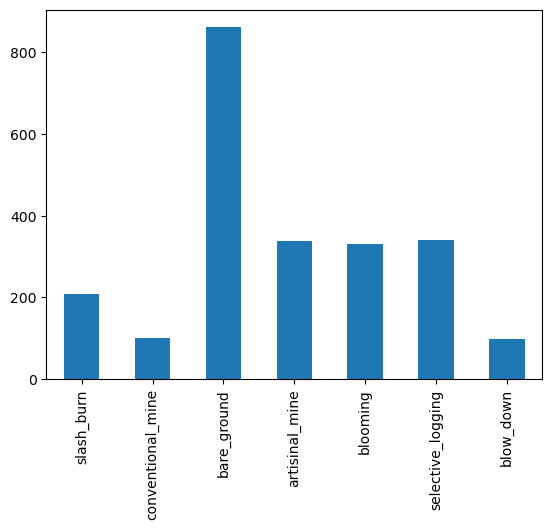

In [21]:
labels_df[rare_labels].sum().plot.bar()

<Axes: >

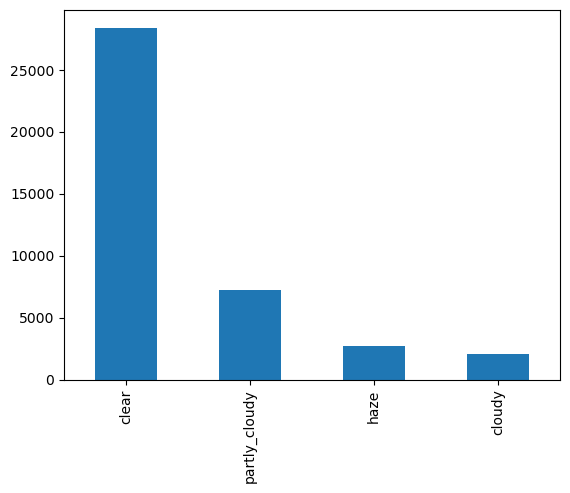

In [22]:
labels_df[weather_labels].sum().plot.bar()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


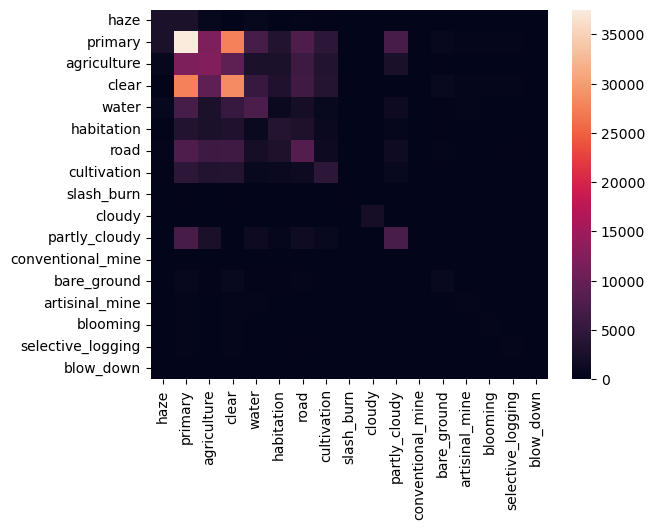

In [7]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


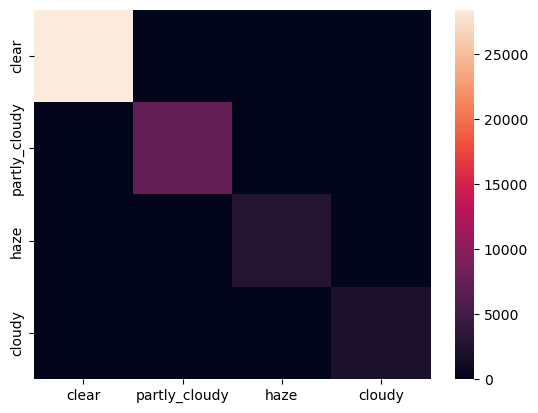

In [8]:
#Each image should have exactly one weather label:

weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

,primary,agriculture,water,cultivation,habitation,road
primary,37513,11972,7001,4455,3469,7728
agriculture,11972,12315,2712,3377,2737,6034
water,7001,2712,7411,868,915,2125
cultivation,4455,3377,868,4477,895,1294
habitation,3469,2737,915,895,3660,2786
road,7728,6034,2125,1294,2786,8071


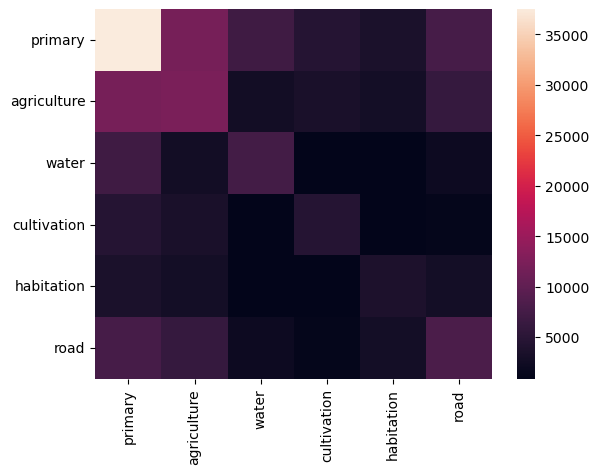

In [9]:
#But the land labels may overlap:

land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation', 'road']
make_cooccurence_matrix(land_labels)

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


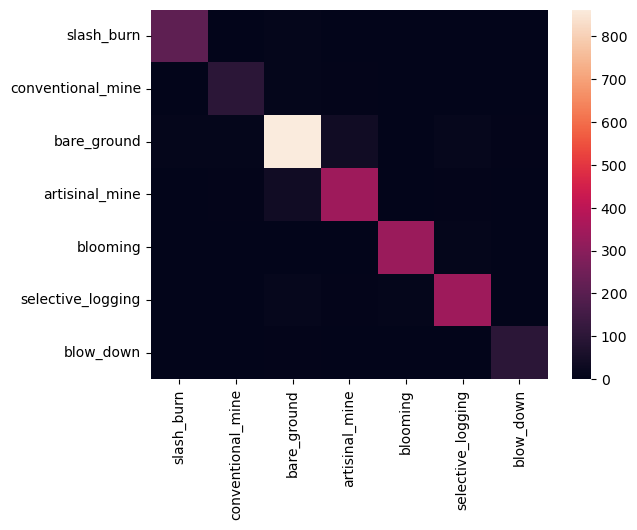

In [10]:
#The rarer labels have very little overlap:

rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)

In [11]:
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [12]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.tif vs. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            print('Found image {}'.format(path))
            return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx, suffix='tif'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.at[sample_df.index[row_idx], 'image_name']
    return '{}.{}'.format(fname, suffix)

In [13]:
def plot_rgbn_histo(r, g, b, n):
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,rgb_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()

In [14]:
s = sample_images(['primary', 'water', 'road'], n=1)
fname = sample_to_fname(s, 0)

# find the image in the data directory and load it
# note the initial bgrn band ordering
bgrn_image = load_image(fname)

Found image C:\Users\rzi\AmazonMLProject\input\train-tif-v2\train_18069.tif


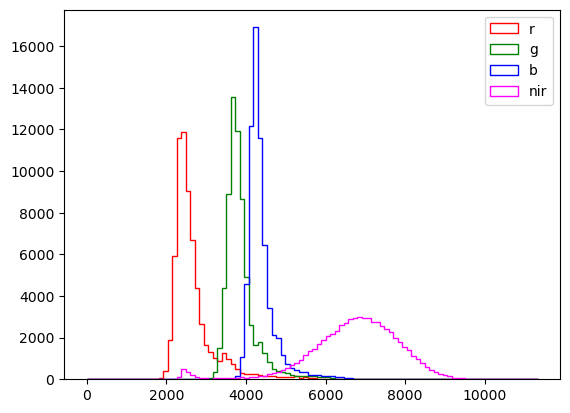

In [15]:
# extract the rgb values
bgr_image = bgrn_image[:,:,:3]
rgb_image = bgr_image[:, :, [2,1,0]]

# extract the different bands
b, g, r, nir = bgrn_image[:, :, 0], bgrn_image[:, :, 1], bgrn_image[:, :, 2], bgrn_image[:, :, 3]

# plot a histogram of rgbn values
plot_rgbn_histo(r, g, b, nir)

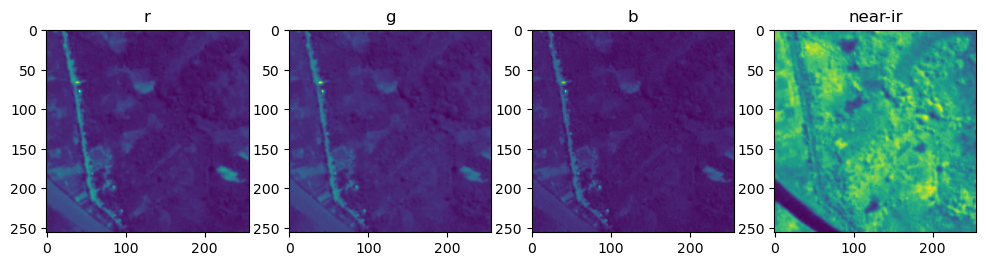

In [16]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

In [17]:
print ("r max", np.amax(r))
print ("r min", np.amin(r))
print ("g max", np.amax(g))
print ("g min", np.amin(g))
print ("b max", np.amax(b))
print ("b min", np.amin(b))
print ("nir max", np.amax(nir))
print ("nir min", np.amin(nir))

r max 8998
r min 1808
g max 9699
g min 3025
b max 11325
b min 3708
nir max 10116
nir min 2205
